In [1]:
! cp /kaggle/input/voc-pascal-2012-segmentation/best.pth .


In [2]:
""" Parts of the U-Net model """
import os
import random
import numpy as np
from glob import glob
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes, bilinear=True):
        super(UNet, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(self.in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, self.num_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [3]:
#read dataset
"""picture agument class"""
class ToTensor(object):
    def __init__(self):
        pass
    def __call__(self,img, mask):
        img = torch.from_numpy(img.copy()).contiguous()/255.0
        img = img.permute(2,0,1)
        mask = torch.from_numpy(mask.copy()).contiguous()
        return img, mask

"""voc mask rgbcolor"""
VOC_COLORMAP = np.array([[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]])

"""voc class names"""
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']


class ListDataset(Dataset):
    def __init__(self, list_path: str, img_size: int = 416, transformList: list = []):
        abs_path = os.path.abspath(list_path)
        prpath = os.path.dirname(abs_path)
        with open(list_path, "r") as file:
            files = file.readlines()
            self.img_files = []
            self.mask_files = []
            for path in files:
                image_file = os.path.join(prpath, "JPEGImages", path.strip() + ".jpg")
                label_file = os.path.join(prpath, "mask", path.strip() + ".png")
                self.img_files.append(image_file)
                self.mask_files.append(label_file)
        self.img_size = img_size
        self.transformList = transformList

    def __getitem__(self, index):
        #  Image
        try:
            img_path = self.img_files[index % len(self.img_files)].rstrip()
            img = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(e)
        #  mask
        try:
            mask_path = self.mask_files[index % len(self.img_files)].rstrip()
            mask = Image.open(mask_path).convert('RGB')
        except Exception as e:
            print(e)
            return
        # transform
        assert img.size == mask.size , "iamge and mask have different size"
        w, h = img.size
        imgsize = max(w, h)
        dw = (imgsize - w) // 2
        dh = (imgsize - h) // 2
        img_pad = Image.new("RGB", (imgsize, imgsize), (0, 0, 0))
        img_pad.paste(img, (dw, dh))
        mask_pad = Image.new("RGB", (imgsize, imgsize), (0, 0, 0))
        mask_pad.paste(mask, (dw, dh))
        img_pad = img_pad.resize((self.img_size, self.img_size), resample=Image.BICUBIC)
        mask_pad = mask_pad.resize((self.img_size, self.img_size), resample=Image.NEAREST)
        img_pad = np.array(img_pad, dtype=np.uint8)
        mask_pad = np.array(mask_pad, dtype=np.uint8)
        mask_label = np.zeros((mask_pad.shape[0], mask_pad.shape[1]), dtype=np.int64)
        for index, color in enumerate(VOC_COLORMAP):
            classmask = np.all(mask_pad == color, axis=-1)
            mask_label[classmask] = index

        try:
            for transform in self.transformList:
                img, mask_label = transform(img_pad, mask_label)
        except Exception as e:
            print("Could not apply transform.")
            print(e)
            #traceback.print_exc()
            return

        return img, mask_label

    def __len__(self):
        return len(self.img_files)

def workerSeedSet(worker_id):
    # NumPy
    uint64_seed = torch.initial_seed()
    ss = np.random.SeedSequence([uint64_seed])
    np.random.seed(ss.generate_state(4))
    # random
    worker_seed = torch.initial_seed() % 2 ** 32
    random.seed(worker_seed)


"""create dataset and dataloader"""
def createDataLoader(list_path: str, batch_size: int, img_size: int = 256, shuffle = True, n_cpu: int = 4, transform: list=[ToTensor()]):

    dataset = ListDataset(list_path, img_size, transform)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=n_cpu,
        pin_memory=True,
        worker_init_fn=workerSeedSet)

    return dataloader


In [4]:
# function to create dice coefficient
def dice_coef(y_true, y_pred, smooth=100):
    y_true_flatten = torch.flatten(y_true)
    y_pred_flatten = torch.flatten(y_pred)

    intersection = torch.sum(y_true_flatten * y_pred_flatten)
    union = torch.sum(y_true_flatten) + torch.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)
    
#evaluate function
def eval_net(net, loader, device):
    net.eval()
    n_val = len(loader)  # the number of batch
    tot = 0
    tot_img = 0
    for imgs, true_masks in tqdm(loader, desc="Validing"):
        imgs = imgs.to(device=device, dtype=torch.float32)
        true_masks = true_masks.to(device=device, dtype=torch.float32 if net.num_classes == 1 else torch.long)
        tot_img += len(imgs)
        with torch.no_grad():
            mask_pred = net(imgs)

        for b in range(imgs.shape[0]):
            if net.num_classes==1:
                    pred = torch.sigmoid(mask_pred[b])
                    pred = (pred > 0.5).float()
                    tot += dice_coef(pred, true_masks[b]).item()
            else:
                gt = F.one_hot(true_masks[b], num_classes=net.num_classes)
                pred = F.one_hot(torch.argmax(mask_pred[b],dim=0), num_classes=net.num_classes)
                tot += dice_coef(pred, gt).item()

    return tot / tot_img

In [5]:
# train function
from torch import optim
from tqdm import tqdm


def train_net(net, device, epochs, lr,train_loader, val_loader):
    optimizer = optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.99), eps=1e-08)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
    if net.num_classes > 1:
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        net.train()
        best_score = 0
        epoch_loss = 0
        for imgs, true_masks in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
            imgs = imgs.to(device=device, dtype=torch.float32)
            true_masks = true_masks.to(device=device, dtype=torch.float32 if net.num_classes == 1 else torch.long)

            masks_pred = net(imgs)
            loss = criterion(masks_pred, true_masks)
            epoch_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        scheduler.step(epoch_loss)    
        val_score = eval_net(net, val_loader, device)
        
        print(f"Epoch {epoch + 1} train loss:{epoch_loss}")
        print(f"Epoch {epoch + 1} evaluation dice score:{val_score}")

        if val_score>best_score:
            torch.save(net.state_dict(),f'best.pth')

In [8]:
# train model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
net = UNet(in_channels=3, num_classes=21, bilinear=True)
net.to(device=device)

train_loader = createDataLoader(list_path = '/kaggle/input/voc-pascal-2012-segmentation/train.txt',
                                batch_size = 16,
                                shuffle = True,
                                img_size = 256, 
                                n_cpu = 2)
val_loader = createDataLoader(list_path = '/kaggle/input/voc-pascal-2012-segmentation/valid.txt',
                                batch_size = 16, 
                                img_size = 256,
                                shuffle = False,
                                n_cpu = 2)

train_net(net=net,
          device=device,
          epochs=50,
          lr=1.0e-4,
          train_loader = train_loader,
          val_loader = val_loader
          )


cuda


Validing: 100%|██████████| 37/37 [00:28<00:00,  1.31it/s]


Epoch 1 train loss:336.1159476041794
Epoch 1 evaluation dice score:0.7632903289529104


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.32it/s]


Epoch 2 train loss:261.524871468544
Epoch 2 evaluation dice score:0.7383119301873661


Validing: 100%|██████████| 37/37 [00:28<00:00,  1.32it/s]


Epoch 3 train loss:211.0501481294632
Epoch 3 evaluation dice score:0.7519829271434715


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.37it/s]


Epoch 4 train loss:174.01895076036453
Epoch 4 evaluation dice score:0.771542362395936


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.32it/s]


Epoch 5 train loss:145.01504200696945
Epoch 5 evaluation dice score:0.7944343844061241


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.34it/s]


Epoch 6 train loss:127.31132674217224
Epoch 6 evaluation dice score:0.8186934995712588


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.35it/s]


Epoch 7 train loss:115.9967585504055
Epoch 7 evaluation dice score:0.8269815984250751


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.36it/s]


Epoch 8 train loss:108.57464373111725
Epoch 8 evaluation dice score:0.8261081432192036


Validing: 100%|██████████| 37/37 [00:28<00:00,  1.32it/s]


Epoch 9 train loss:103.36892279982567
Epoch 9 evaluation dice score:0.8157289612456824


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.32it/s]


Epoch 10 train loss:99.9934022128582
Epoch 10 evaluation dice score:0.8235441101762893


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.32it/s]


Epoch 11 train loss:96.35352393984795
Epoch 11 evaluation dice score:0.8323357290816757


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.36it/s]


Epoch 12 train loss:93.11558994650841
Epoch 12 evaluation dice score:0.8289142464180549


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.33it/s]


Epoch 13 train loss:90.90222465991974
Epoch 13 evaluation dice score:0.8311803207491519


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.33it/s]


Epoch 14 train loss:89.49061840772629
Epoch 14 evaluation dice score:0.8375097986048736


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.34it/s]


Epoch 15 train loss:86.20198515057564
Epoch 15 evaluation dice score:0.835043838563955


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.37it/s]


Epoch 16 train loss:84.0798282623291
Epoch 16 evaluation dice score:0.8402615310192926


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.33it/s]


Epoch 17 train loss:81.61949062347412
Epoch 17 evaluation dice score:0.8343966317013238


Validing: 100%|██████████| 37/37 [00:28<00:00,  1.32it/s]


Epoch 18 train loss:79.90553256869316
Epoch 18 evaluation dice score:0.8426820102114211


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.33it/s]


Epoch 19 train loss:76.99882599711418
Epoch 19 evaluation dice score:0.841744376292155


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.33it/s]


Epoch 20 train loss:74.93085244297981
Epoch 20 evaluation dice score:0.844576816104902


Validing: 100%|██████████| 37/37 [00:28<00:00,  1.32it/s]


Epoch 21 train loss:71.70676413178444
Epoch 21 evaluation dice score:0.8361841329272779


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.33it/s]


Epoch 22 train loss:68.27094277739525
Epoch 22 evaluation dice score:0.8355447991430044


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.33it/s]


Epoch 23 train loss:67.2411815226078
Epoch 23 evaluation dice score:0.8410303758307142


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.34it/s]


Epoch 24 train loss:63.31640666723251
Epoch 24 evaluation dice score:0.8419500160483103


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.34it/s]


Epoch 25 train loss:61.10963651537895
Epoch 25 evaluation dice score:0.8396483752269484


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.34it/s]


Epoch 26 train loss:59.31626193225384
Epoch 26 evaluation dice score:0.8360936687188942


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.34it/s]


Epoch 27 train loss:56.26305544376373
Epoch 27 evaluation dice score:0.840503316698516


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.34it/s]


Epoch 28 train loss:52.966554284095764
Epoch 28 evaluation dice score:0.8388203484218689


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.34it/s]


Epoch 29 train loss:49.991333201527596
Epoch 29 evaluation dice score:0.8449002499236864


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.33it/s]


Epoch 30 train loss:47.153033807873726
Epoch 30 evaluation dice score:0.8195575137796778


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.33it/s]


Epoch 31 train loss:45.674124389886856
Epoch 31 evaluation dice score:0.8364820675109713


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.34it/s]


Epoch 32 train loss:42.9284632652998
Epoch 32 evaluation dice score:0.8391135226596486


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.36it/s]


Epoch 33 train loss:41.46441300213337
Epoch 33 evaluation dice score:0.8474328989741323


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.34it/s]


Epoch 34 train loss:37.901440277695656
Epoch 34 evaluation dice score:0.8373790861300703


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.33it/s]


Epoch 35 train loss:37.609028950333595
Epoch 35 evaluation dice score:0.8369930958052647


Validing: 100%|██████████| 37/37 [00:26<00:00,  1.38it/s]


Epoch 36 train loss:34.20494231581688
Epoch 36 evaluation dice score:0.8315325220903034


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.34it/s]


Epoch 37 train loss:31.862937167286873
Epoch 37 evaluation dice score:0.8419554035209669


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.34it/s]


Epoch 38 train loss:30.132931038737297
Epoch 38 evaluation dice score:0.8453646458647059


Validing: 100%|██████████| 37/37 [00:26<00:00,  1.38it/s]


Epoch 39 train loss:29.000144012272358
Epoch 39 evaluation dice score:0.8397966364133419


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.34it/s]


Epoch 40 train loss:27.813616305589676
Epoch 40 evaluation dice score:0.8449930391221676


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.33it/s]


Epoch 41 train loss:27.17994076013565
Epoch 41 evaluation dice score:0.8396516704538879


Validing: 100%|██████████| 37/37 [00:26<00:00,  1.37it/s]


Epoch 42 train loss:26.590111054480076
Epoch 42 evaluation dice score:0.8434489203255949


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.34it/s]


Epoch 43 train loss:22.797376811504364
Epoch 43 evaluation dice score:0.8174755844202909


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.35it/s]


Epoch 44 train loss:24.77588153630495
Epoch 44 evaluation dice score:0.8486099373517274


Validing: 100%|██████████| 37/37 [00:26<00:00,  1.37it/s]


Epoch 45 train loss:22.053609438240528
Epoch 45 evaluation dice score:0.8424901009935049


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.33it/s]


Epoch 46 train loss:21.415388010442257
Epoch 46 evaluation dice score:0.8359411199853515


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.33it/s]


Epoch 47 train loss:21.509767159819603
Epoch 47 evaluation dice score:0.8478280435704448


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.33it/s]


Epoch 48 train loss:19.814474754035473
Epoch 48 evaluation dice score:0.8264025458954211


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.33it/s]


Epoch 49 train loss:18.702214788645506
Epoch 49 evaluation dice score:0.8387591247902113


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.33it/s]


Epoch 50 train loss:18.550008438527584
Epoch 50 evaluation dice score:0.8342927527161855


Validing: 100%|██████████| 37/37 [00:27<00:00,  1.33it/s]


the valid dice score is 0.834.
show some sammple


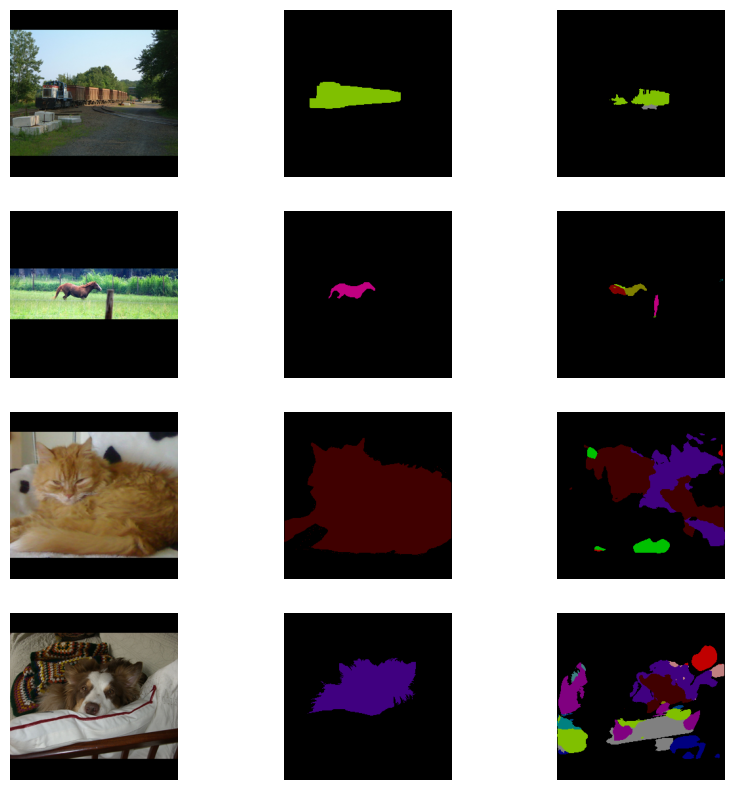

In [9]:
#test
import matplotlib.pyplot as plt

net.load_state_dict(torch.load(f'best.pth'))
net.eval()

dice_score = eval_net(net, val_loader, device)
print("the valid dice score is {:.3f}.".format(dice_score))

#show some sammple
print("show some sammple")
train_dataset = ListDataset(list_path = '/kaggle/input/voc-pascal-2012-segmentation/train.txt', img_size = 256 , transformList = [ToTensor()])
valid_dataset = ListDataset(list_path = '/kaggle/input/voc-pascal-2012-segmentation/valid.txt', img_size = 256 , transformList = [ToTensor()])

images, masks = zip(*[valid_dataset[i] for i in range(100,401,100)])
images = torch.stack(images)


with torch.no_grad():
    pre = net(images.to(device)).argmax(dim=1).cpu()

plt.figure(figsize=(10,10)) #设置窗口大小
for i, img in enumerate(images):
    img = img.permute(1,2,0).numpy()*255
    img = img.astype(np.uint8)
    gt_masks = np.zeros_like(img)
    pr_masks = np.zeros_like(img)
    for cls in range(21):
       gt_masks[masks[i]==cls]= VOC_COLORMAP[cls]
       pr_masks[pre[i]==cls]= VOC_COLORMAP[cls]

    plt.subplot(4,3,1+3*i), plt.imshow(img), plt.axis('off')
    plt.subplot(4,3,2+3*i), plt.imshow(gt_masks), plt.axis('off')
    plt.subplot(4,3,3+3*i), plt.imshow(pr_masks), plt.axis('off')

plt.show()

Validing: 100%|██████████| 37/37 [00:27<00:00,  1.33it/s]


the valid dice score is 0.834.
show some sammple


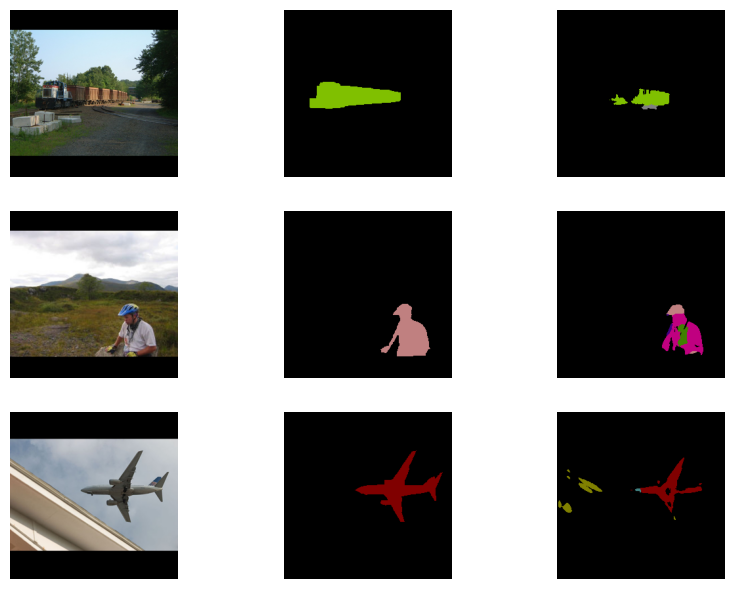

In [16]:
#test
import matplotlib.pyplot as plt

net.load_state_dict(torch.load(f'best.pth'))
net.eval()

dice_score = eval_net(net, val_loader, device)
print("the valid dice score is {:.3f}.".format(dice_score))

#show some sammple
print("show some sammple")
train_dataset = ListDataset(list_path = '/kaggle/input/voc-pascal-2012-segmentation/train.txt', img_size = 256 , transformList = [ToTensor()])
valid_dataset = ListDataset(list_path = '/kaggle/input/voc-pascal-2012-segmentation/valid.txt', img_size = 256 , transformList = [ToTensor()])

images, masks = zip(*[valid_dataset[i] for i in range(100,201,40)])
images = torch.stack(images)


with torch.no_grad():
    pre = net(images.to(device)).argmax(dim=1).cpu()

plt.figure(figsize=(10,10)) #设置窗口大小
for i, img in enumerate(images):
    img = img.permute(1,2,0).numpy()*255
    img = img.astype(np.uint8)
    gt_masks = np.zeros_like(img)
    pr_masks = np.zeros_like(img)
    for cls in range(21):
       gt_masks[masks[i]==cls]= VOC_COLORMAP[cls]
       pr_masks[pre[i]==cls]= VOC_COLORMAP[cls]

    plt.subplot(4,3,1+3*i), plt.imshow(img), plt.axis('off')
    plt.subplot(4,3,2+3*i), plt.imshow(gt_masks), plt.axis('off')
    plt.subplot(4,3,3+3*i), plt.imshow(pr_masks), plt.axis('off')

plt.show()

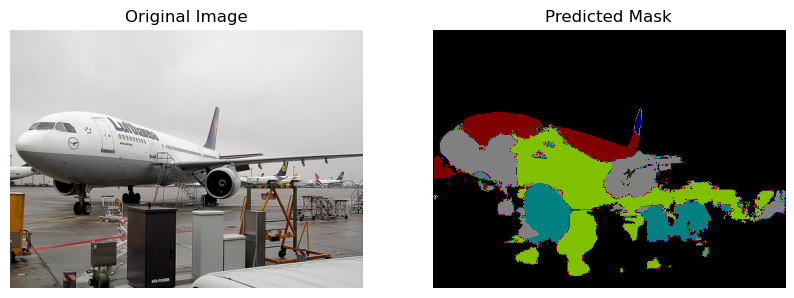

In [42]:
# Đường dẫn đến ảnh mới của bạn
new_img_path = '/kaggle/input/voc-pascal-2012-segmentation/JPEGImages/2007_000033.jpg'
new_img = Image.open(new_img_path).convert('RGB')

# Sử dụng transforms.ToTensor() để chuyển đổi ảnh thành tensor
transform = transforms.ToTensor()
new_img = transform(new_img)

with torch.no_grad():
    new_pred = net(new_img.unsqueeze(0).to(device)).argmax(dim=1).cpu()

# Hiển thị ảnh gốc và ảnh dự đoán
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(new_img.permute(1, 2, 0).numpy()), plt.title('Original Image'), plt.axis('off')
plt.subplot(122), plt.imshow(new_pred[0].numpy(), cmap=cmap), plt.title('Predicted Mask'), plt.axis('off')

plt.show()

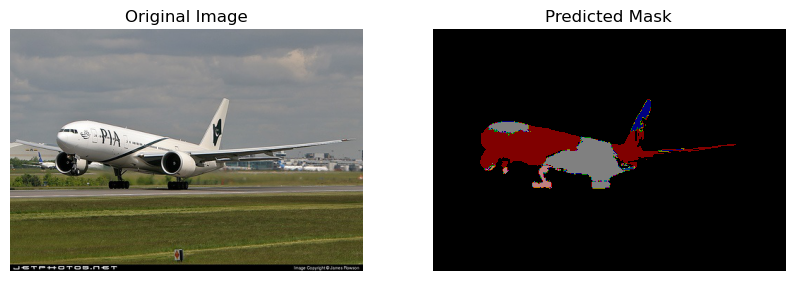

In [41]:
# Đường dẫn đến ảnh mới của bạn
new_img_path = '/kaggle/input/voc-pascal-2012-segmentation/JPEGImages/2007_000256.jpg'
new_img = Image.open(new_img_path).convert('RGB')

# Sử dụng transforms.ToTensor() để chuyển đổi ảnh thành tensor
transform = transforms.ToTensor()
new_img = transform(new_img)

with torch.no_grad():
    new_pred = net(new_img.unsqueeze(0).to(device)).argmax(dim=1).cpu()

# Hiển thị ảnh gốc và ảnh dự đoán
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(new_img.permute(1, 2, 0).numpy()), plt.title('Original Image'), plt.axis('off')
plt.subplot(122), plt.imshow(new_pred[0].numpy(), cmap=cmap), plt.title('Predicted Mask'), plt.axis('off')

plt.show()

Validing: 100%|██████████| 37/37 [00:27<00:00,  1.33it/s]


the valid dice score is 0.834.


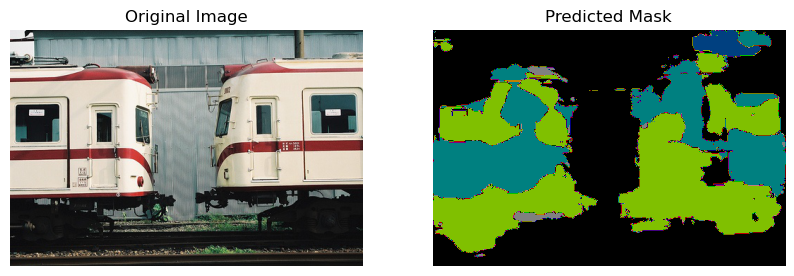

In [40]:
import matplotlib.pyplot as plt

net.load_state_dict(torch.load(f'best.pth'))
net.eval()

dice_score = eval_net(net, val_loader, device)
print("the valid dice score is {:.3f}.".format(dice_score))

# Đường dẫn đến ảnh mới của bạn
new_img_path = '/kaggle/input/voc-pascal-2012-segmentation/JPEGImages/2007_000042.jpg'
new_img = Image.open(new_img_path).convert('RGB')

# Sử dụng transforms.ToTensor() để chuyển đổi ảnh thành tensor
transform = transforms.ToTensor()
new_img = transform(new_img)

with torch.no_grad():
    new_pred = net(new_img.unsqueeze(0).to(device)).argmax(dim=1).cpu()

# Hiển thị ảnh gốc và ảnh dự đoán
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(new_img.permute(1, 2, 0).numpy()), plt.title('Original Image'), plt.axis('off')
plt.subplot(122), plt.imshow(new_pred[0].numpy(), cmap=cmap), plt.title('Predicted Mask'), plt.axis('off')

plt.show()

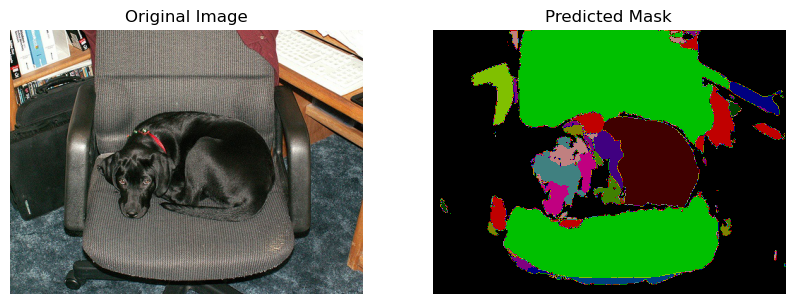

In [50]:
# Đường dẫn đến ảnh mới của bạn
new_img_path = '/kaggle/input/voc-pascal-2012-segmentation/JPEGImages/2007_000063.jpg'
new_img = Image.open(new_img_path).convert('RGB')

# Sử dụng transforms.ToTensor() để chuyển đổi ảnh thành tensor
transform = transforms.ToTensor()
new_img = transform(new_img)

with torch.no_grad():
    new_pred = net(new_img.unsqueeze(0).to(device)).argmax(dim=1).cpu()

# Hiển thị ảnh gốc và ảnh dự đoán
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(new_img.permute(1, 2, 0).numpy()), plt.title('Original Image'), plt.axis('off')
plt.subplot(122), plt.imshow(new_pred[0].numpy(), cmap=cmap), plt.title('Predicted Mask'), plt.axis('off')

plt.show()

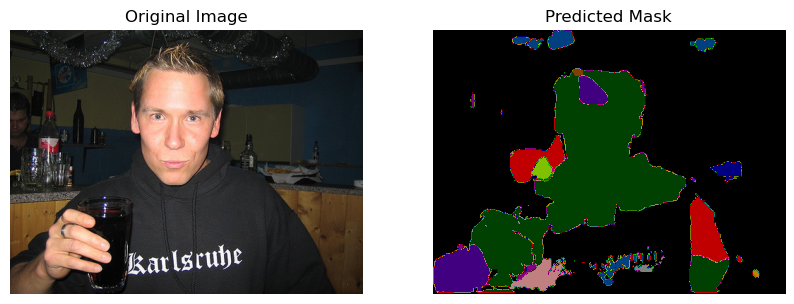

In [52]:
# Đường dẫn đến ảnh mới của bạn
new_img_path = '/kaggle/input/voc-pascal-2012-segmentation/JPEGImages/2007_000170.jpg'
new_img = Image.open(new_img_path).convert('RGB')

# Sử dụng transforms.ToTensor() để chuyển đổi ảnh thành tensor
transform = transforms.ToTensor()
new_img = transform(new_img)

with torch.no_grad():
    new_pred = net(new_img.unsqueeze(0).to(device)).argmax(dim=1).cpu()

# Hiển thị ảnh gốc và ảnh dự đoán
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(new_img.permute(1, 2, 0).numpy()), plt.title('Original Image'), plt.axis('off')
plt.subplot(122), plt.imshow(new_pred[0].numpy(), cmap=cmap), plt.title('Predicted Mask'), plt.axis('off')

plt.show()